In [24]:
from models.cifrador_homomorfico_parcial import CifradorHomomorficoParcial
from models.cifrador_homomorfico_completo import CifradorHomomorficoCompleto
from models.cifrador_asimetrico import CifradorAsimetrico
import time
import random
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [25]:
# Las librerías de seaborn tiran un warning, puse esta celda para ignorarlas
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)

In [26]:
def wrapped(func):
    def wrapper(*args, **kwargs):
        start = time.time()
        result = func(*args, **kwargs)
        end = time.time()
        elapsed = end - start
        return result, elapsed

    return wrapper

In [27]:
@wrapped
def encriptar(cifrador, numero):
    return cifrador.encriptar(numero)


@wrapped
def desencriptar(cifrador, numero):
    return cifrador.desencriptar(numero)


@wrapped
def suma(numero1, numero2):
    return numero1 + numero2


@wrapped
def resta(numero1, numero2):
    return numero1 - numero2


@wrapped
def multiplicacion(numero1, numero2):
    return numero1 * numero2

In [28]:
def tiempos_operacion_cifrador(cifrador, numeros, operacion):
    tiempos = []
    numeros_operacion = []
    for numero in numeros:
        numero_operado, elapsed_time = operacion(cifrador, numero)
        tiempos.append(elapsed_time)
        numeros_operacion.append(numero_operado)
    return tiempos, numeros_operacion


def tiempos_operaciones_algebraicas(numeros1, numeros2, operacion):
    if len(numeros1) != len(numeros2):
        raise ValueError("Las listas de numeros tienen diferentes longitudes")
    tiempos = []
    numeros_operacion = []
    for numero1, numero2 in zip(numeros1, numeros2):
        numero_operado, elapsed_time = operacion(numero1, numero2)
        tiempos.append(elapsed_time)
        numeros_operacion.append(numero_operado)
    return tiempos, numeros_operacion

In [29]:
def tiempos_cifrado(cifrador, numeros):
    return tiempos_operacion_cifrador(cifrador, numeros, encriptar)


def tiempos_descifrado(cifrador, numeros_encriptados):
    return tiempos_operacion_cifrador(cifrador, numeros_encriptados, desencriptar)


def tiempos_suma(numeros1, numeros2):
    return tiempos_operaciones_algebraicas(numeros1, numeros2, suma)


def tiempos_resta(numeros1, numeros2):
    return tiempos_operaciones_algebraicas(numeros1, numeros2, resta)


def tiempos_multiplicacion(numeros1, numeros2):
    return tiempos_operaciones_algebraicas(numeros1, numeros2, multiplicacion)

In [30]:
def guardar_plot(titulo):
    %matplotlib inline
    titulo_archivo = titulo.lower().replace(' ', '_')
    plt.savefig(os.getcwd() + f'/imagenes/{titulo_archivo}.png')

In [31]:
def barplot_tiempos(tiempos, titulo, xlabel):
    sns.set(style="whitegrid")

    plt.figure(figsize=(10, 6))

    sns.histplot(tiempos, bins=10, kde=True, color='skyblue', stat='count', edgecolor='black')

    plt.xlabel(xlabel, fontsize=12)
    plt.ylabel('Frecuencia', fontsize=12)
    plt.title(titulo, fontsize=16)

    plt.grid(axis='y', linestyle='--', alpha=0.7)
    guardar_plot(titulo)
    plt.show()

In [32]:
def plot_precision_comparison(precision_ckks, precision_parcial, random_numbers):
    def calcular_presicion_relativa(original, decrypted):
        return (1 - (original - decrypted) / original) * 100

    precision_ckks = [calcular_presicion_relativa(original, decrypted) for original, decrypted in
                      zip(random_numbers, precision_ckks)]
    precision_parcial = [calcular_presicion_relativa(original, decrypted) for original, decrypted in
                         zip(random_numbers, precision_parcial)]

    sns.set(style="whitegrid")

    fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

    plt.subplots_adjust(top=0.85, hspace=0.5)

    sns.boxplot(y=precision_ckks, ax=axes[0], color='skyblue')
    axes[0].set_title('Precisión Cifrador Homomórfico Completo CKKS')
    axes[0].set_ylabel('Precisión Relativa')

    sns.boxplot(y=precision_parcial, ax=axes[1], color='lightcoral')
    axes[1].set_title('Precisión Cifrador Homomórfico Parcial')
    titulo = 'Comparación de precisión entre cifradores al desencriptar'
    plt.suptitle(titulo, fontsize=16)
    guardar_plot(titulo)
    plt.show()

# Análisis de tiempos de cifrado

Generamos los números aleatorios

In [33]:
random.seed(42)
numeros_random_enteros = [random.randint(1, 10000) for _ in range(500)]
numeros_random_floats = [random.uniform(1.0, 10000.0) for _ in range(500)]

Instanciamos los cifradores

In [34]:
cifrador_homomorfico_parcial = CifradorHomomorficoParcial()
cifrador_homomorfico_completo_bfv = CifradorHomomorficoCompleto()
cifrador_homomorfico_completo_ckks = CifradorHomomorficoCompleto(context_gen_params='CKKS')
cifrador_homomorfico_asimetrico_rsa = CifradorAsimetrico()

Encriptamos con los distintos cifradores y tomamos el tiempo

In [35]:
ruta_archivo = os.getcwd() + '/datos/datos_encriptados.pkl'

if os.path.exists(ruta_archivo):
    print('Cargamos los datos')
    with open(ruta_archivo, 'rb') as file:
        loaded_data = pickle.load(file)
    
    tiempos_del_parcial, numeros_encriptados_parcial = loaded_data['tiempos_del_parcial'], loaded_data['numeros_encriptados_parcial']
    tiempos_del_completo_bfv, numeros_encriptados_completo_bfv = loaded_data['tiempos_del_completo_bfv'], loaded_data['numeros_encriptados_completo_bfv']
    tiempos_del_completo_ckks, numeros_encriptados_completo_ckks = loaded_data['tiempos_del_completo_ckks'], loaded_data['numeros_encriptados_completo_ckks']
    tiempos_del_asimetrico_rsa, numeros_encriptados_asimetricos = loaded_data['tiempos_del_asimetrico_rsa'], loaded_data['numeros_encriptados_asimetricos']
else:
    print('Creamos los datos')
    tiempos_del_parcial, numeros_encriptados_parcial = tiempos_cifrado(cifrador_homomorfico_parcial,
                                                                       numeros_random_floats)
    tiempos_del_completo_bfv, numeros_encriptados_completo_bfv = tiempos_cifrado(cifrador_homomorfico_completo_bfv,
                                                                                 numeros_random_enteros)
    tiempos_del_completo_ckks, numeros_encriptados_completo_ckks = tiempos_cifrado(cifrador_homomorfico_completo_ckks,
                                                                                   numeros_random_floats)
    tiempos_del_asimetrico_rsa, numeros_encriptados_asimetricos = tiempos_cifrado(cifrador_homomorfico_asimetrico_rsa,
                                                                                  numeros_random_enteros)

    data = {'tiempos_del_parcial': tiempos_del_parcial,
            'numeros_encriptados_parcial': numeros_encriptados_parcial,
            'tiempos_del_completo_bfv': tiempos_del_completo_bfv,
            'numeros_encriptados_completo_bfv': numeros_encriptados_completo_bfv,
            'tiempos_del_completo_ckks': tiempos_del_completo_ckks,
            'numeros_encriptados_completo_ckks': numeros_encriptados_completo_ckks,
            'tiempos_del_asimetrico_rsa': tiempos_del_asimetrico_rsa,
            'numeros_encriptados_asimetricos': numeros_encriptados_asimetricos
            }

    with open(ruta_archivo, 'wb+') as file:
        pickle.dump(data, file)

Cargamos los datos


Comparamos los tiempos

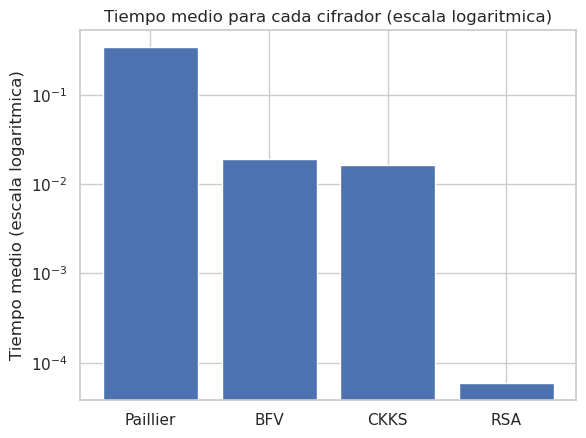

In [36]:
avg1 = np.mean(tiempos_del_parcial)
avg2 = np.mean(tiempos_del_completo_bfv)
avg3 = np.mean(tiempos_del_completo_ckks)
avg4 = np.mean(tiempos_del_asimetrico_rsa)

# Create bar plot with logarithmic scale
lists = ['Paillier', 'BFV', 'CKKS', 'RSA']
averages = [avg1, avg2, avg3, avg4]

plt.bar(lists, averages)
plt.yscale('log')  # Set y-axis to logarithmic scale
plt.ylabel('Tiempo medio (escala logaritmica)')
plt.title('Tiempo medio para cada cifrador (escala logaritmica)')
plt.show()

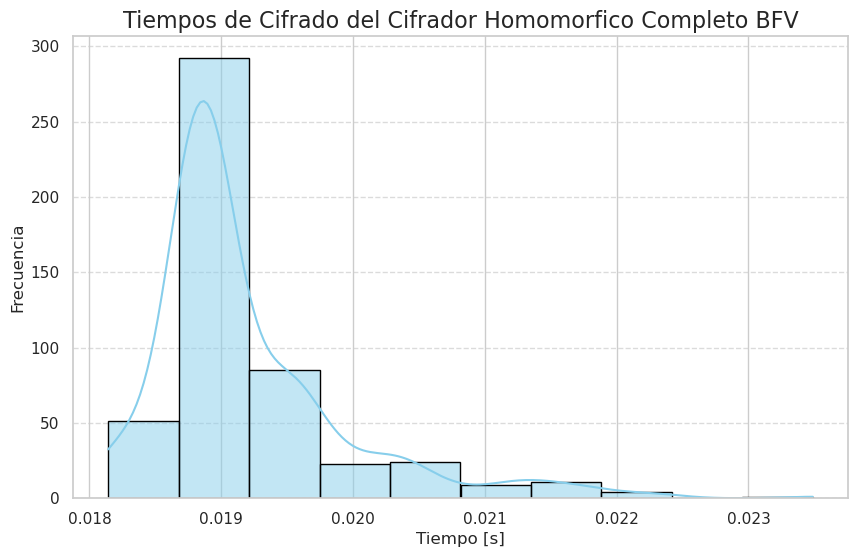

In [37]:
barplot_tiempos(tiempos_del_completo_bfv, 'Tiempos de Cifrado del Cifrador Homomorfico Completo BFV',
                'Tiempo [s]')

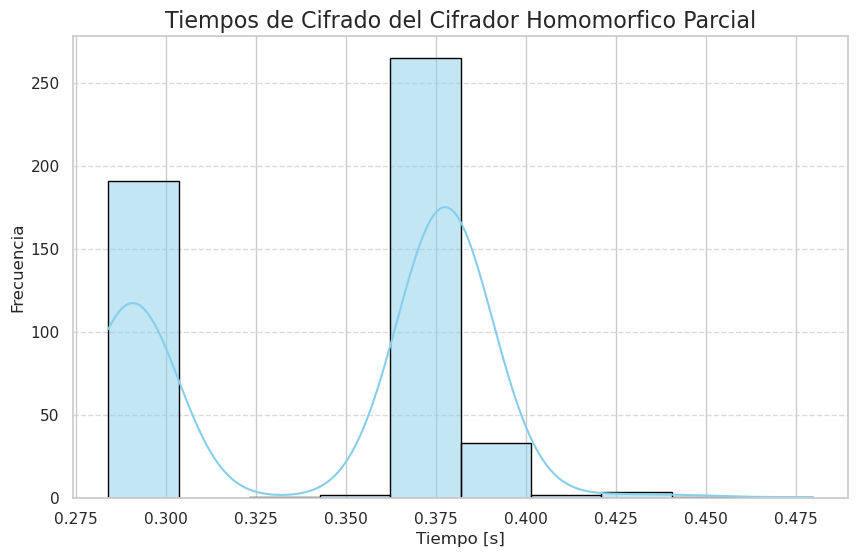

In [38]:
barplot_tiempos(tiempos_del_parcial, 'Tiempos de Cifrado del Cifrador Homomorfico Parcial', 'Tiempo [s]')

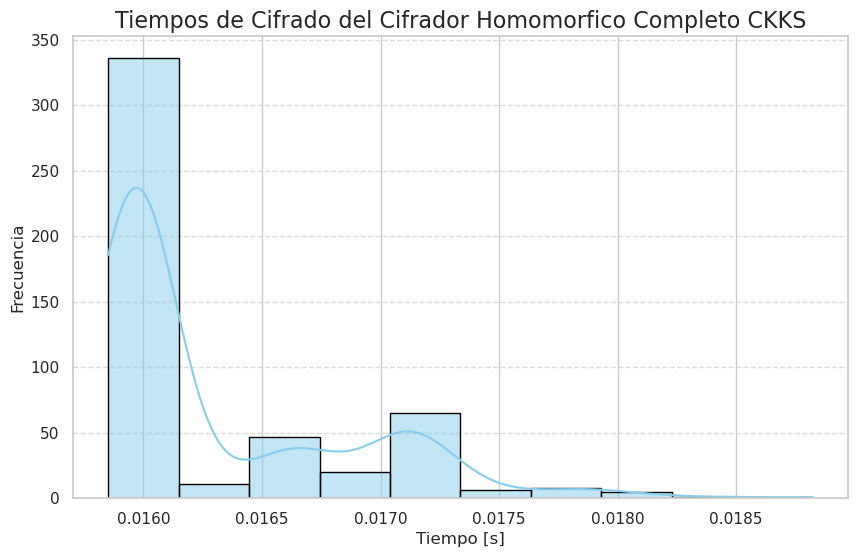

In [39]:
barplot_tiempos(tiempos_del_completo_ckks, 'Tiempos de Cifrado del Cifrador Homomorfico Completo CKKS',
                'Tiempo [s]')

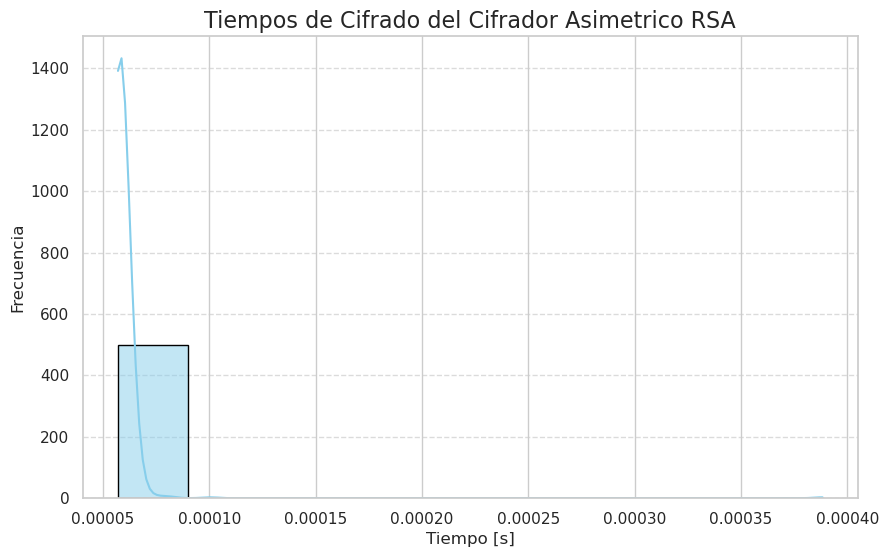

In [40]:
barplot_tiempos(tiempos_del_asimetrico_rsa, 'Tiempos de Cifrado del Cifrador Asimetrico RSA', 'Tiempo [s]')

# Análisis de tiempos para desencriptar

In [42]:
ruta_archivo = os.getcwd() + '/datos/datos_desencriptados.pkl'

if os.path.exists(ruta_archivo):
    print('Cargamos los datos')
    with open(ruta_archivo, 'rb') as file:
        loaded_data = pickle.load(file)

    tiempos_desencriptado_parcial, numeros_desencriptados_parcial = loaded_data['tiempos_desencriptado_parcial'], loaded_data['numeros_desencriptados_parcial']
    tiempos_desencriptado_completo_bfv, numeros_desencriptados_completo_bfv = loaded_data['tiempos_desencriptado_completo_bfv'], loaded_data['numeros_desencriptados_completo_bfv']
    tiempos_desencriptado_completo_ckks, numeros_desencriptados_completo_ckks = loaded_data['tiempos_desencriptado_completo_ckks'], loaded_data['numeros_desencriptados_completo_ckks']
    tiempos_desencriptado_asimetricos, numeros_desencriptados_asimetricos = loaded_data['tiempos_desencriptado_asimetricos'], loaded_data['numeros_desencriptados_asimetricos']
    
else:
    print('Creamos los datos')
    tiempos_desencriptado_parcial, numeros_desencriptados_parcial = tiempos_descifrado(cifrador_homomorfico_parcial, numeros_encriptados_parcial)
    tiempos_desencriptado_completo_bfv, numeros_desencriptados_completo_bfv = tiempos_descifrado(cifrador_homomorfico_completo_bfv, numeros_encriptados_completo_bfv)
    tiempos_desencriptado_completo_ckks, numeros_desencriptados_completo_ckks = tiempos_descifrado(cifrador_homomorfico_completo_ckks, numeros_encriptados_completo_ckks)
    tiempos_desencriptado_asimetricos, numeros_desencriptados_asimetricos = tiempos_descifrado(cifrador_homomorfico_asimetrico_rsa, numeros_encriptados_asimetricos)

    data = {
            'tiempos_desencriptado_parcial': tiempos_desencriptado_parcial,
            'numeros_desencriptados_parcial': numeros_desencriptados_parcial,
            'tiempos_desencriptado_completo_bfv': tiempos_desencriptado_completo_bfv,
            'numeros_desencriptados_completo_bfv': numeros_desencriptados_completo_bfv,
            'tiempos_desencriptado_completo_ckks': tiempos_desencriptado_completo_ckks,
            'numeros_desencriptados_completo_ckks': numeros_desencriptados_completo_ckks,
            'tiempos_desencriptado_asimetricos': tiempos_desencriptado_asimetricos,
            'numeros_desencriptados_asimetricos': numeros_desencriptados_asimetricos
            }

    with open(ruta_archivo, 'wb+') as file:
        pickle.dump(data, file)

Cargamos los datos


KeyError: 'tiempos_desencriptado_asimetricos'

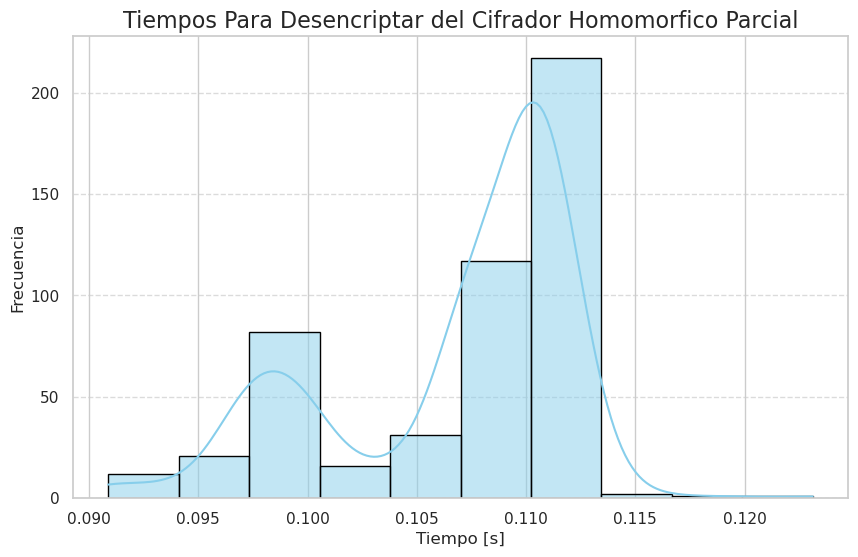

In [43]:
barplot_tiempos(tiempos_desencriptado_parcial, 'Tiempos Para Desencriptar del Cifrador Homomorfico Parcial',
                'Tiempo [s]')

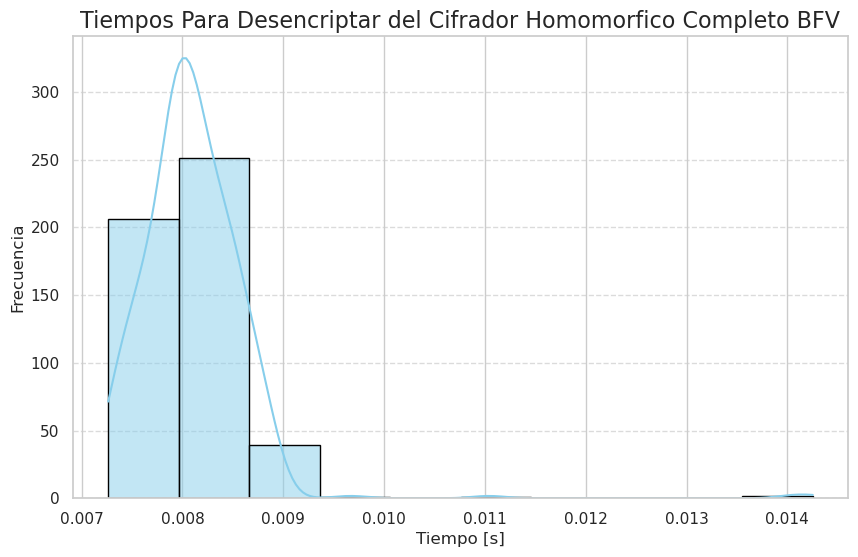

In [44]:
barplot_tiempos(tiempos_desencriptado_completo_bfv, 'Tiempos Para Desencriptar del Cifrador Homomorfico Completo BFV',
                'Tiempo [s]')

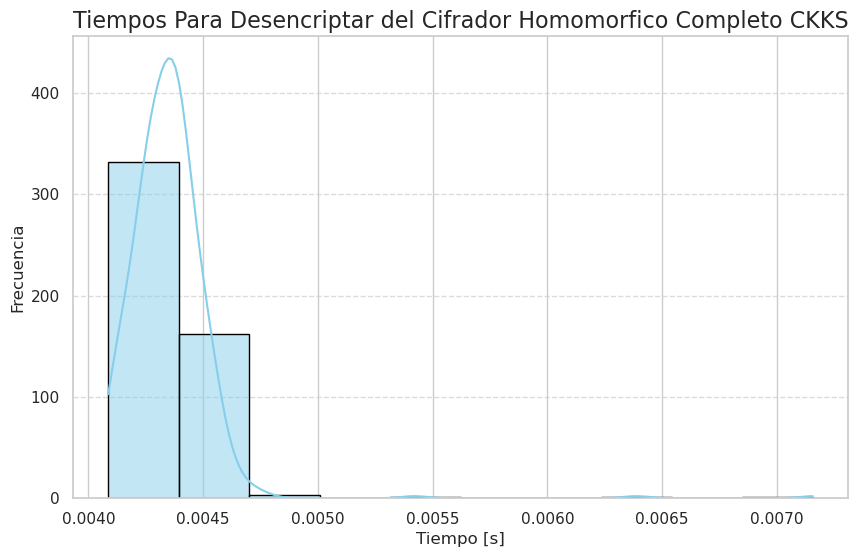

In [45]:
barplot_tiempos(tiempos_desencriptado_completo_ckks, 'Tiempos Para Desencriptar del Cifrador Homomorfico Completo CKKS',
                'Tiempo [s]')

## Además verificamos la presición de los numeros

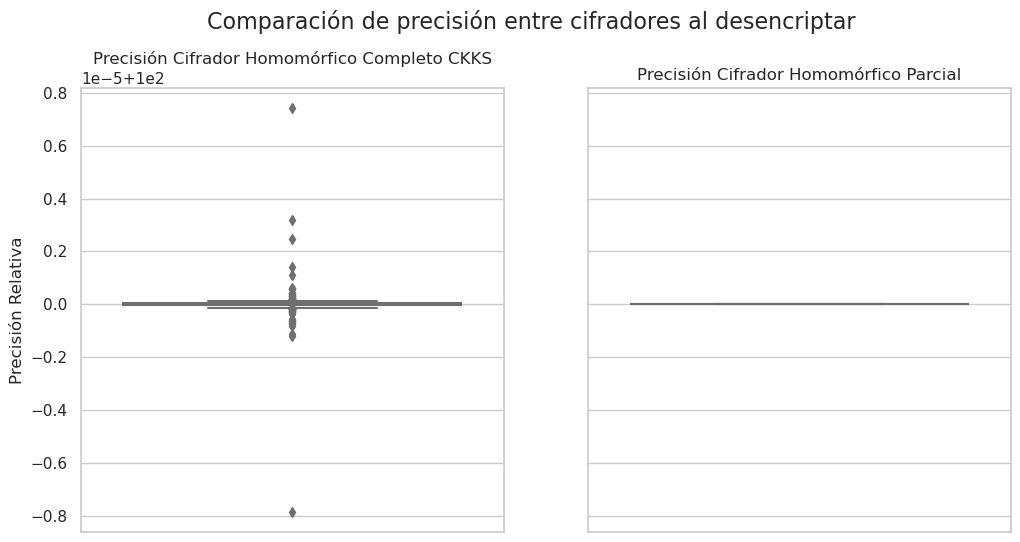

In [46]:
plot_precision_comparison(numeros_desencriptados_completo_ckks, numeros_desencriptados_parcial, numeros_random_floats)

In [47]:
barplot_tiempos(tiempos_desencriptado_asimetricos, 'Tiempos Para Desencriptar del Cifrador Asimetrico RSA',
                'Tiempo [s]')

NameError: name 'tiempos_desencriptado_asimetricos' is not defined

# Análisis de tiempos de suma

In [48]:
mitad = len(numeros_encriptados_parcial) // 2
numeros_encriptados_parcial1 = numeros_encriptados_parcial[mitad:]
numeros_encriptados_parcial2 = numeros_encriptados_parcial[:mitad]

tiempo_suma_encriptados_parcial, suma_encriptada_parcial = tiempos_suma(numeros_encriptados_parcial1,
                                                                        numeros_encriptados_parcial2)

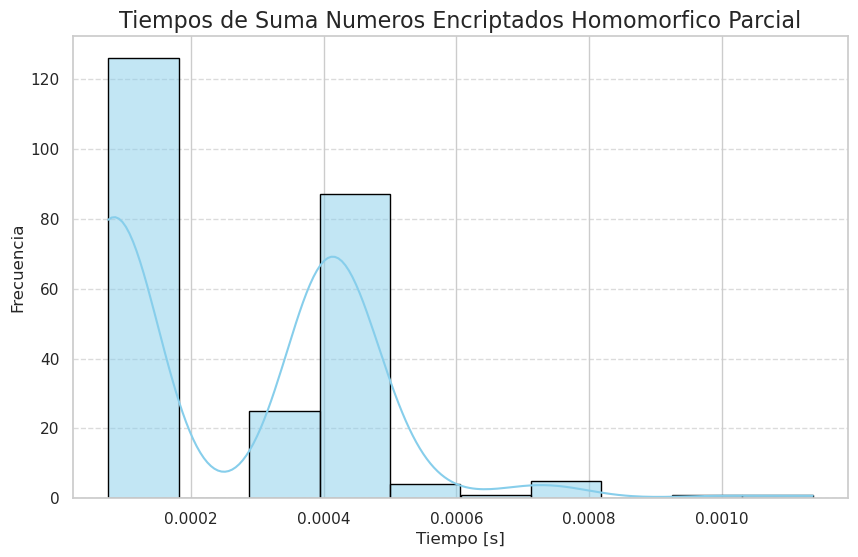

In [49]:
barplot_tiempos(tiempo_suma_encriptados_parcial, titulo='Tiempos de Suma Numeros Encriptados Homomorfico Parcial',
                xlabel='Tiempo [s]')

In [50]:
mitad = len(numeros_encriptados_completo_bfv) // 2
numeros_encriptados_completo_bfv1 = numeros_encriptados_completo_bfv[mitad:]
numeros_encriptados_completo_bfv2 = numeros_encriptados_completo_bfv[:mitad]

tiempo_suma_encriptados_completo_bfv, suma_encriptada_completo_bfv = tiempos_suma(numeros_encriptados_completo_bfv1,
                                                                                  numeros_encriptados_completo_bfv2)

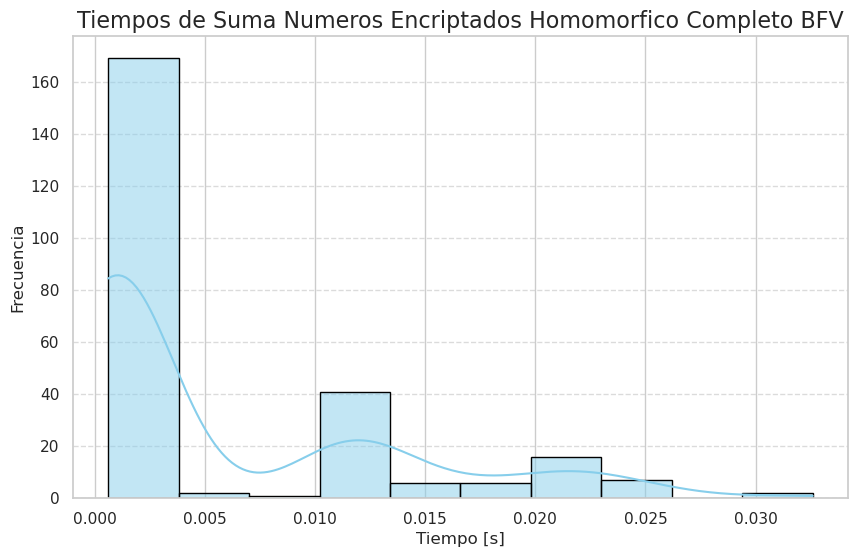

In [51]:
barplot_tiempos(tiempo_suma_encriptados_completo_bfv,
                titulo='Tiempos de Suma Numeros Encriptados Homomorfico Completo BFV',
                xlabel='Tiempo [s]')

In [52]:
mitad = len(numeros_encriptados_completo_ckks) // 2
numeros_encriptados_completo_ckks1 = numeros_encriptados_completo_ckks[mitad:]
numeros_encriptados_completo_ckks2 = numeros_encriptados_completo_ckks[:mitad]

tiempo_suma_encriptados_completo_ckks, suma_encriptada_completo_ckks = tiempos_suma(numeros_encriptados_completo_ckks1,
                                                                                    numeros_encriptados_completo_ckks2)

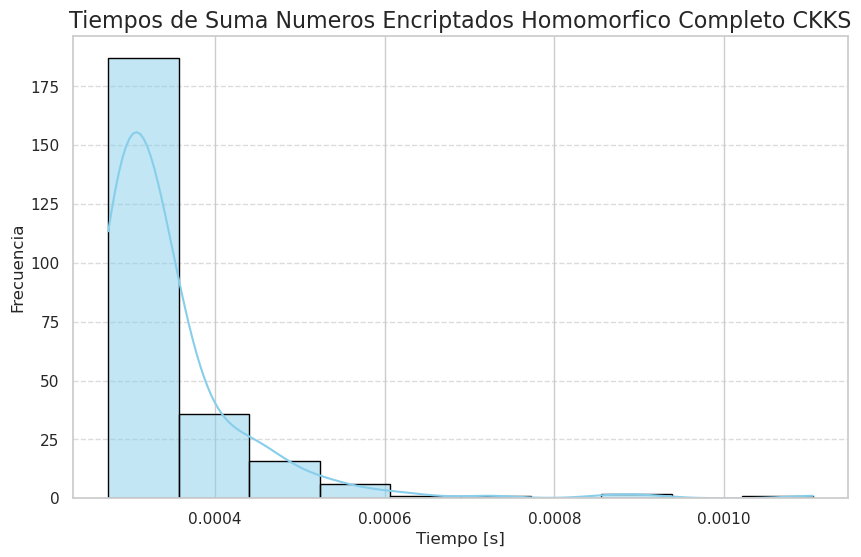

In [53]:
barplot_tiempos(tiempo_suma_encriptados_completo_ckks,
                titulo='Tiempos de Suma Numeros Encriptados Homomorfico Completo CKKS',
                xlabel='Tiempo [s]')

## Presision

In [54]:
sumas_desencriptadas_parcial = tiempos_descifrado(cifrador_homomorfico_parcial, suma_encriptada_parcial)[1]
sumas_desencriptadas_completo_bfv = tiempos_descifrado(cifrador_homomorfico_completo_bfv, suma_encriptada_completo_bfv)[
    1]
sumas_desencriptadas_completo_ckks = \
    tiempos_descifrado(cifrador_homomorfico_completo_ckks, suma_encriptada_completo_ckks)[1]

ValueError: encrypted_number was encrypted against a different key!

In [ ]:
def sumar_mitades(lista_de_numeros):
    midpoint = len(lista_de_numeros) // 2

    first_half = lista_de_numeros[:midpoint]
    second_half = lista_de_numeros[midpoint:]

    return [a + b for a, b in zip(first_half, second_half)]

In [ ]:
sumas_random_enteros = sumar_mitades(numeros_random_enteros)
sumas_random_floats = sumar_mitades(numeros_random_floats)

In [ ]:
results = [sumas_random_enteros, sumas_desencriptadas_completo_bfv]

# Create a boxplot
plt.boxplot(results, labels=['Standard', 'BFV'])
plt.ylabel('Result of Multiplication')
plt.title('Comparison of Multiplication Methods')

plt.show()


# Análisis de tiempos de resta

In [ ]:
mitad = len(numeros_encriptados_parcial) // 2
numeros_encriptados_parcial1 = numeros_encriptados_parcial[mitad:]
numeros_encriptados_parcial2 = numeros_encriptados_parcial[:mitad]

tiempo_resta_encriptados_parcial, resta_encriptada_parcial = tiempos_resta(numeros_encriptados_parcial1,
                                                                           numeros_encriptados_parcial2)

In [ ]:
barplot_tiempos(tiempo_resta_encriptados_parcial, titulo='Tiempos de Resta Numeros Encriptados Homomorfico Parcial',
                xlabel='Tiempo [s]')

In [ ]:
mitad = len(numeros_encriptados_completo_bfv) // 2
numeros_encriptados_completo_bfv1 = numeros_encriptados_completo_bfv[mitad:]
numeros_encriptados_completo_bfv2 = numeros_encriptados_completo_bfv[:mitad]

tiempo_resta_encriptados_completo_bfv, resta_encriptada_completo_bfv = tiempos_resta(numeros_encriptados_completo_bfv1,
                                                                                     numeros_encriptados_completo_bfv2)

In [ ]:
barplot_tiempos(tiempo_resta_encriptados_completo_bfv,
                titulo='Tiempos de Resta Numeros Encriptados Homomorfico Completo BFV',
                xlabel='Tiempo [s]')

In [ ]:
mitad = len(numeros_encriptados_completo_ckks) // 2
numeros_encriptados_completo_ckks1 = numeros_encriptados_completo_ckks[mitad:]
numeros_encriptados_completo_ckks2 = numeros_encriptados_completo_ckks[:mitad]

tiempo_resta_encriptados_completo_ckks, resta_encriptada_completo_ckks = tiempos_resta(
    numeros_encriptados_completo_ckks1,
    numeros_encriptados_completo_ckks2)

In [ ]:
barplot_tiempos(tiempo_resta_encriptados_completo_ckks,
                titulo='Tiempos de Resta Numeros Encriptados Homomorfico Completo CKKS',
                xlabel='Tiempo [s]')

# Análisis de tiempos de multiplicación

## Multiplicación de dos números encriptados

In [ ]:
tiempo_multiplicacion_encriptados_completo_bfv, multiplicacion_encriptada_completo_bfv = tiempos_multiplicacion(
    numeros_encriptados_completo_bfv1,
    numeros_encriptados_completo_bfv2)

In [ ]:
barplot_tiempos(tiempo_multiplicacion_encriptados_completo_bfv,
                titulo='Tiempos de Multiplicación Numeros Encriptados Homomorfico Completo BFV',
                xlabel='Tiempo [s]')

In [ ]:
tiempo_multiplicacion_encriptados_completo_ckks, multiplicacion_encriptada_completo_ckks = tiempos_multiplicacion(
    numeros_encriptados_completo_ckks1,
    numeros_encriptados_completo_ckks2)

In [ ]:
barplot_tiempos(tiempo_multiplicacion_encriptados_completo_ckks,
                titulo='Tiempos de Multiplicación Numeros Encriptados Homomorfico Completo CKKS',
                xlabel='Tiempo [s]')

## Multiplicación número encriptado con número sin encriptar

In [ ]:
tiempo_multiplicacion_encriptados_parcial, multiplicacion_encriptada_parcial = tiempos_multiplicacion(
    numeros_encriptados_parcial,
    numeros_random_floats)

In [ ]:
barplot_tiempos(tiempo_multiplicacion_encriptados_parcial,
                titulo='Tiempos de Multiplicación Numeros Encriptados Homomorfico Parcial con Números Sin Encriptar',
                xlabel='Tiempo [s]')